#### Pytorch Built-in Transformer on IC

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim
from einops import rearrange
from torch import nn, einsum

from torch.utils.data import DataLoader
import sys
import os

#Custom
import utilities
torch.max_split_size_mb = 6000
device = torch.device("cuda:0")

#### Import Dataset, Calculate Means and Covariances of Bonds and Angles

In [3]:
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'decaalanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

whole_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 160000, #256 is the default batch size
                          shuffle = True)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 256, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data0, _) in enumerate(whole_loader):
    #Flatten the data into a tensor of size (256, 60) tensor before putting it into the GPU
    data0 = utilities.flatten_data(data0).to(device) #for deccalanine
    #tr_cov, tr_means, bonds_angles_dist = utilities.return_ba_mean_covar(data, dec=True)

#del tr_cov, tr_means, whole_loader

In [4]:
unimodal_indx = torch.tensor([1, 4, 5, 7, 8, 10, 11, 15, 16, 19, 21, 24, 25, 27, 28, 30, 31, 35, 36, 39, 41, 44, 45, 47, 48, 50, 51, 55, 56, 59, 61, 64, 65, 67, 68, 70, 71, 75, 76, 79, 81, 84, 85, 87, 88, 90, 91, 94, 97, 98]).to(device)
pi_indx = torch.tensor([0, 2, 13, 18, 20, 22, 33, 38, 40, 42, 53, 58, 60, 73, 78, 80, 82, 93, 95]).to(device)
multimodal_indx = torch.tensor([3, 6, 9, 12, 14, 17, 23, 26, 29, 32, 34, 37, 43, 46, 49, 52, 54, 57, 62, 63, 66, 69, 72, 74, 77, 83, 86, 89, 92, 96]).to(device)

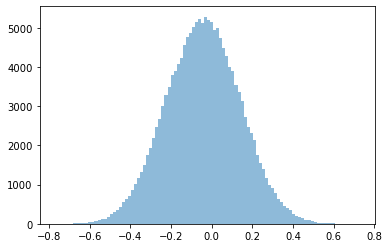

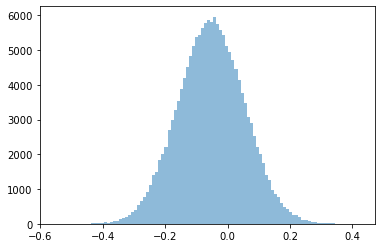

In [7]:
bonds_angles = data0[:, :-99] #99+99+3
dihedrals = data0[:, 201:] #99

#gather special dihedrals
unimodal_dihedrals = torch.index_select(dihedrals, 1, unimodal_indx)
pi_dihedrals = torch.index_select(dihedrals, 1, pi_indx)
multi_dihedrals = torch.index_select(dihedrals, 1, multimodal_indx)

#convert to pi_dihedrals to unimodal step
trans_pi_dihedrals = torch.where(pi_dihedrals < 0, pi_dihedrals + 2*torch.pi, pi_dihedrals)
trans_pi_dihedrals = trans_pi_dihedrals - torch.pi

for index in range(0, 2, 1):
    plt.hist(trans_pi_dihedrals.cpu().numpy()[:, index], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
    plt.show()

In [8]:
"""
#convert to unimodal step
m = torch.where(pi_dihedral < 0, pi_dihedral + 2*torch.pi, pi_dihedral)
m = m - torch.pi

#convert to divided step
m = torch.where(m < 0, m + torch.pi, m)
m = torch.where(m < 2, m - torch.pi, m)
"""

'\n#convert to unimodal step\nm = torch.where(pi_dihedral < 0, pi_dihedral + 2*torch.pi, pi_dihedral)\nm = m - torch.pi\n\n#convert to divided step\nm = torch.where(m < 0, m + torch.pi, m)\nm = torch.where(m < 2, m - torch.pi, m)\n'

In [9]:
unimodal_data = torch.cat([bonds_angles, unimodal_dihedrals, trans_pi_dihedrals], dim=1)
unimodal_data = unimodal_data.permute(1, 0)
np_unimodal_data = unimodal_data.cpu().numpy()

covmat = np.cov(np_unimodal_data)
means = np.mean(np_unimodal_data, axis = 1)

tr_cov = torch.tensor(covmat).double()
tr_means = torch.tensor(means).double()

unimodal_dist = dist.MultivariateNormal(loc = tr_means, covariance_matrix = tr_cov)

#### Model

In [10]:
def custom_bucketize(input_, num_bins, lower_bound = -torch.pi, upper_bound = torch.pi, right=True):
    bounds = torch.linspace(start=lower_bound, end=upper_bound, steps=num_bins).to(device)
    return torch.bucketize(input_, bounds).to(device)

def un_bucketize_dict(num_bins, lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = dict()
    data_range = upper_bound - lower_bound
    delta = data_range/num_bins
    lower_value = lower_bound + delta/2
    for iter in range(0, num_bins+1, 1):
        unbucket_dict[iter] = lower_value
        lower_value = lower_value + delta
    return unbucket_dict

def un_bucketize(input_, num_bins, device=torch.device('cuda:0'), 
                lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = un_bucketize_dict(num_bins, lower_bound=-torch.pi, upper_bound=torch.pi)
    np_input = input_.cpu().numpy()
    return torch.tensor( np.vectorize(unbucket_dict.get)(np_input) ).to(device)

def return_unimodal_multimodal(flattened_data):
    flattened_data = flattened_data.to(device)
    bonds_angles = flattened_data[:, :-99].to(device)
    dihedrals = flattened_data[:, 201:].to(device)
    
    unimodal_dihedrals = torch.index_select(dihedrals, 1, unimodal_indx).to(device)
    pi_dihedrals = torch.index_select(dihedrals, 1, pi_indx).to(device)
    multi_dihedrals = torch.index_select(dihedrals, 1, multimodal_indx).to(device)
    
    unimodal_data = torch.cat([bonds_angles, unimodal_dihedrals, pi_dihedrals], dim=1).to(device)
    
    return unimodal_data, multi_dihedrals

In [11]:
####################################
### Positional Embedding in MSHA ###
####################################
#https://theaisummer.com/positional-embeddings/

def relative_to_absolute(q):
    b, h, l, _, device, dtype = *q.shape, q.device, q.dtype
    dd = {'device': device, 'dtype': dtype}
    col_pad = torch.zeros((b, h, l, 1), **dd)
    x = torch.cat((q, col_pad), dim=3)  # zero pad 2l-1 to 2l
    flat_x = rearrange(x, 'b h l c -> b h (l c)')
    flat_pad = torch.zeros((b, h, l - 1), **dd)
    flat_x_padded = torch.cat((flat_x, flat_pad), dim=2)
    final_x = flat_x_padded.reshape(b, h, l + 1, 2 * l - 1)
    final_x = final_x[:, :, :l, (l - 1):]
    return final_x

def rel_pos_emb_1d(q, rel_emb, shared_heads):
    if shared_heads:
        emb = torch.einsum('b h t d, r d -> b h t r', q, rel_emb)
    else:
        emb = torch.einsum('b h t d, h r d -> b h t r', q, rel_emb)
    return relative_to_absolute(emb)

class PosEmb1D(nn.Module):
    def __init__(self, tokens, dim_head, heads=None):
        super().__init__()
        scale = dim_head ** -0.5
        self.shared_heads = heads if heads is not None else True
        if self.shared_heads:
            self.rel_pos_emb = nn.Parameter(torch.randn(2 * tokens - 1, dim_head) * scale)
        else:
            self.rel_pos_emb = nn.Parameter(torch.randn(heads, 2 * tokens - 1, dim_head) * scale)
        scale = dim_head ** -0.5
        self.abs_pos_emb = nn.Parameter(torch.randn(tokens, dim_head) * scale)

    def forward(self, q):
        #q_2 = q.clone()
        abs_emb = einsum('b h i d, j d -> b h i j', q, self.abs_pos_emb)
        #rel_emb = rel_pos_emb_1d(q_2, self.rel_pos_emb, self.shared_heads)
        return abs_emb #+ rel_emb

##############################
### Encoder, Decoder, Attn ###
##############################

class DecoderLayer(nn.Module):
    """Implements a single layer of an unconditional ImageTransformer"""
    def __init__(self):
        self.hidden_size = 512
        self.filter_size = 128
        self.unconditional = False

        super().__init__()
        self.attn = Attn()
        self.dropout = nn.Dropout(p=0.10)
        self.layernorm_attn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_attn2 = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.ffn = nn.Sequential(nn.Linear(self.hidden_size, self.filter_size, bias=True), nn.ReLU(),
                                 nn.Linear(self.filter_size, self.hidden_size, bias=True))

    def forward(self, X, encoder_output = None):
        #the first layer of a decoder is just normal self-attention
        y = self.attn(X, use_encoder_output=False, autoregressive_mask=True)
        X = self.layernorm_attn(self.dropout(y) + X)
        #the second layer of a decoder uses outputs from the encoder as query and key values
        y = self.attn(X, encoder_output = encoder_output, 
            use_encoder_output=True, autoregressive_mask=True)
        X = self.layernorm_attn2(self.dropout(y) + X)
        #the last layer is just feed forward and layer norm
        y = self.ffn(X)
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X

class EncoderLayer(nn.Module):
    "The encoder is also identical to the decoder, except that the decoder has masking operation" 
    def __init__(self):
        self.hidden_size = 512
        self.filter_size = 128

        super().__init__()
        self.attn = Attn()
        self.dropout = nn.Dropout(p=0.10)
        self.layernorm_attn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.ffn = nn.Sequential(nn.Linear(self.hidden_size, self.filter_size, bias=True),
                                 nn.ReLU(), nn.Linear(self.filter_size, self.hidden_size, bias=True))

    def forward(self, X):
        y = self.attn(X, autoregressive_mask=False)
        X = self.layernorm_attn(self.dropout(y) + X)
        y = self.ffn(X)
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X

class Attn(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 512
        self.kd = 192
        self.vd = 192
        self.num_heads = 6

        self.q_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.k_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.v_dense = nn.Linear(self.hidden_size, self.vd, bias=False)
        self.output_dense = nn.Linear(self.vd, self.hidden_size, bias=False)
        
        assert self.kd % self.num_heads == 0
        assert self.vd % self.num_heads == 0
        
        #embedding in multiheaded attention
        self.q_embedding = PosEmb1D(tokens=30, dim_head=int((self.kd/self.num_heads)), heads=self.num_heads)

    def dot_product_attention(self, q, k, v, bias=None):
        logits = torch.einsum("...kd,...qd->...qk", k, q)
        if bias is not None:
            logits += bias
        weights = F.softmax(logits, dim=-1)
        return weights @ v

    def forward(self, X, encoder_output=None, autoregressive_mask=True, use_encoder_output=False):
        if use_encoder_output == False: 
            q = self.q_dense(X)
            k = self.k_dense(X)
            v = self.v_dense(X)
        elif use_encoder_output == True: 
            v = self.v_dense(X)
            q = self.q_dense(encoder_output.clone())
            k = self.k_dense(encoder_output.clone())

        #Split to shape [batch_size, num_heads, len, depth / num_heads]
        q = q.view(q.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        k = k.view(k.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        v = v.view(v.shape[:-1] + (self.num_heads, self.vd // self.num_heads)).permute([0, 2, 1, 3])
        q *= (self.kd // self.num_heads) ** (-0.5) #normalized dot product or something
        
        if autoregressive_mask == True: 
            bias = -1e9 * torch.triu(torch.ones(X.shape[1], X.shape[1]), 1).to(X.device)
            bias = bias + self.q_embedding(q)
            result = self.dot_product_attention(q, k, v, bias=bias)
        elif autoregressive_mask == False: 
            bias = self.q_embedding(q)
            result = self.dot_product_attention(q, k, v, bias=bias)

        result = result.permute([0, 2, 1, 3]).contiguous()
        result = result.view(result.shape[0:2] + (-1,))
        result = self.output_dense(result)

        return result
    
##########################
### Actual Transformer ###
##########################

class TransformerIC(nn.Module):
    def __init__(self, given_unimodal_dist, batch_size = 256):
        super(TransformerIC, self).__init__()
        #model specific params
        self.hidden_size = 512
        self.num_bins = 200
        self.dropout = 0.05
        self.nlayers = 12
        #data specific params
        self.batch_size = 256
        self.num_unimodal = 270 #99+99+3+19+50 
        self.num_multimodal = 30 #99 #19
        #given unimodal dist
        self.unimodal_dist = given_unimodal_dist
        #functions
        self.output_function = torch.nn.Softmax(dim=1)
        self.loss_function = nn.CrossEntropyLoss()
        self.loss_function_no_sum = nn.CrossEntropyLoss(reduction="none")
        #model components
        self.embeds = nn.Embedding(self.num_bins, self.hidden_size)
        self.input_dropout = nn.Dropout(self.dropout)
        self.output_dense = nn.Linear(self.hidden_size, self.num_bins, bias=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(self.nlayers)])
        self.encoderlayers = nn.ModuleList([EncoderLayer() for _ in range(self.nlayers)])
        #reshape encoder output
        self.vd = 128
        self.pos_embedder_0 = torch.nn.Embedding(self.num_unimodal, self.hidden_size)
        
        self.ba_embeds = nn.Linear(self.num_unimodal, self.hidden_size*self.num_multimodal)
        
        self.encoder_reshape = nn.Linear(self.hidden_size, self.vd, bias=False)
        #positional embedding as opposed to add_timing_signal
        self.pos_embedder_1 = torch.nn.Embedding(self.num_multimodal, self.hidden_size)
        self.pos_embedder_2 = torch.nn.Embedding(self.num_multimodal, self.hidden_size)
    
    def shift_and_pad_(self, X): 
        """   For the purpose of autoregressive property. Shift inputs over by 1 and pad.
        x should be [256, 19, 8]. Pad 2nd to last dimension, 
        since 1st dimension is batch and last is embedding. """
        X = X[:, :-1, :]
        X = F.pad(X, (0, 0, 1, 0)) #kinda need to figure out how this works
        return X

    def forward(self, dihedrals, ba=None, encoder_output=None, sampling=False, return_encoder=False):
        if encoder_output == None:
            encoder_output = self.ba_embeds(ba)
            encoder_output = encoder_output.view((ba.shape[0], self.num_multimodal, self.hidden_size)) * (self.hidden_size ** 0.5)
        
            pos_index = torch.arange(0, self.num_multimodal).repeat(ba.size()[0], 1).to(device)
            pos_embeddings = self.pos_embedder_0(pos_index)
            encoder_output = pos_embeddings + encoder_output
            
            for layer in self.encoderlayers:
                encoder_output = layer(encoder_output)
    
            if return_encoder == True:
                return encoder_output
        
        if sampling:
            curr_infer_length = dihedrals.shape[1]
            dihedrals = F.pad(dihedrals, (0, self.num_multimodal - curr_infer_length))  
        
        dihedrals = self.embeds(dihedrals) * (self.hidden_size ** 0.5)
        dihedrals = self.shift_and_pad_(dihedrals)
        
        pos_index = torch.arange(0, self.num_multimodal).repeat(dihedrals.size()[0], 1).to(device)
        
        dihedrals = dihedrals + self.pos_embedder_1(pos_index)
        
        for layer in self.layers:
            dihedrals = layer(dihedrals, encoder_output = encoder_output) 
        
        #pos_index_2 = torch.arange(0, self.num_multimodal).repeat(dihedrals.size()[0], 1).to(device)
        #dihedrals = dihedrals + self.pos_embedder_2(pos_index_2)
        dihedrals = self.output_dense(dihedrals) 
        
        return dihedrals

    def sample(self, batch_size, device, conditional=True, detach=False): #batch size is num samples
        """sampling procedure does not require gradients"""
        if conditional == True:
            ba_data = self.unimodal_dist.sample(torch.tensor([batch_size])).to(device).float()
            encoder_output = self.forward(dihedrals=None, ba = ba_data, return_encoder=True)
            if detach==True:
                ba_data = ba_data.detach()
        else:
            raise NotImplementedError

        total_len = self.num_multimodal
        samples = torch.zeros((batch_size, 1)).to(device).long()
        if detach == True:
            samples = samples.detach()

        for curr_infer_length in range(total_len):
            outputs = self.forward(encoder_output = encoder_output, dihedrals = samples, sampling=True)
            outputs = outputs[:, curr_infer_length]
            categorical = self.output_function(outputs) #outputs is energy
            temp_distribution = dist.Categorical(torch.squeeze(categorical))
            x = temp_distribution.sample()
            x = x.unsqueeze(dim=1)#print(categorical.size()) = [10, 629]
            if curr_infer_length == 0:
                samples = x
            else:
                samples = torch.cat([samples, x], 1)

        dihedrals = samples
        return ba_data, dihedrals

    def loss(self, X, Y, with_energy=False, reduce=True):
        #X is a categorical distribution and Y is the target (one hot encoding).
        X = X.permute(0, 2, 1)
        #X.size() = [256, 19, 629] after permuting; Y.size() = [256, 19]
        #256 = batchsize, 629 = number classes, 19 = number of dihedrals
        if reduce==False:
            return self.loss_function_no_sum(X, Y)
        loss_value = self.loss_function(X, Y) #nn.CrossEntropyLoss automatically applies softmax
        return loss_value
    
    def exact_log_likelihood(self, ba, dihedrals):
        #dihedrals should be represented as indicies already
        dist = self.forward(dihedrals=dihedrals, ba=ba)
        #dist = dist.permute(0, 2, 1)
        ba_loss = self.unimodal_dist.log_prob(ba.cpu())
        dihedral_loss = self.loss(dist.to(device), dihedrals.to(device), reduce=False).to(device) #+ \
        #self.ba_dist.log_prob(ba.to(device)).to(device)    
        dihedral_loss = torch.sum(dihedral_loss, dim=1)
        loss = torch.add(ba_loss.to(device), dihedral_loss.to(device))
        return loss

    def energy_loss(self, batch_size, device, sum=False):
        ba, dihedral = model.sample(batch_size, device=device)
        dihedral_true = utilities.index_to_number(dihedral)
        q_s = (-model.exact_log_likelihood(ba=ba, dihedrals=dihedral))
        E_s = dataset_train.compute_potential_energy_for_ic(
            utilities.rebuild(
                torch.cat([ba, dihedral_true], dim=1).cpu().detach()
            ), unitless=False
        )
        return torch.sum(torch.add(torch.tensor(E_s).to(device), q_s.to(device)))

device = torch.device("cuda:0")
model = TransformerIC(given_unimodal_dist = unimodal_dist).to(device)
#ba = torch.randn((256,41)).to(device)
#dihedrals = torch.ones((256, 19)).to(device).long()
#model.forward(dihedrals, ba = ba)

#### Training Loop

In [1]:
loss_over_time = []
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-5) 

def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = utilities.flatten_data(data)
        data = data.to(device)
        
        unimodal_data, multi_dihedrals = return_unimodal_multimodal(data)
        target = custom_bucketize(multi_dihedrals, 200)
        
        optimizer.zero_grad()
        X_pred = model(ba=unimodal_data, dihedrals=target) 
        
        loss = model.loss(X = X_pred, Y=target)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        energy = 0
        
        if batch_idx % 25 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            '''
            ba, dihedrals = model.sample(64, device=device)
            dihedrals = utilities.index_to_number(dihedrals)
            np_samples = np.array(dihedrals.cpu().detach())
            ba = ba.cpu().detach().numpy()
            whole = np.concatenate((ba, np_samples), axis=1)
            molecules = utilities.rebuild(torch.tensor(whole))
            potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(molecules)
            energy = float(torch.median(torch.tensor(potential_energy_q_theta)))
            '''               
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                loss.item() / len(train_loader))#,#,  #hardcoded batch size
                #"Energy:", energy 
            )
                           
            loss_over_time.append( (loss.item()/len(train_loader), energy) )

for epoch in range(0, 11, 1):
    train(epoch)

NameError: name 'model' is not defined

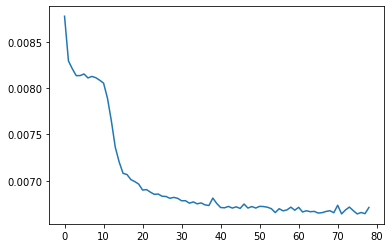

In [13]:
ls = np.array(loss_over_time)
plt.plot(ls[:, 0])
plt.show()

### Sample From Model to View Distribtuions

In [14]:
sample_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 3000, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(sample_loader):
    data = utilities.flatten_data(data)
    np_data = np.array(data)
    break

del sample_loader

torch.cuda.empty_cache()
torch.cuda.synchronize()
device = torch.device("cuda:1")
model.to(device)

ba, dihedrals = model.sample(300, device=device)

for index in range(0, 9, 1):
    new_ba, new_dihedrals = model.sample(300, device=device)
    ba = torch.cat([ba, new_ba], dim=0)
    dihedrals = torch.cat([dihedrals, new_dihedrals], dim=0)
    
#dihedrals = utilities.index_to_number(dihedrals)
#np_samples = np.array(dihedrals.cpu().detach())
#ba = ba.cpu().detach().numpy()
#whole = np.concatenate((ba, np_samples), axis=1)
#molecules = utilities.rebuild(torch.tensor(whole))
#potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(molecules)

In [15]:
bonds_angles = ba[:, 0:201].cpu() #[3000, 201]
unimodal = ba[:, 201:201+50].cpu() #[3000, 50]
pi = ba[:, 201+50:].cpu() #[3000, 19]

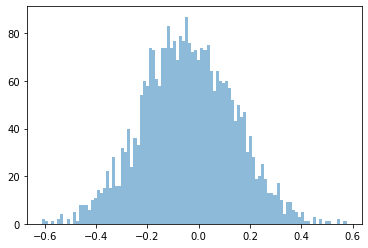

In [16]:
pi_0 = pi[: , 0]

plt.hist(pi_0.numpy(), label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
plt.show()

In [17]:
#process pi_angles
pi = torch.where(pi < 0, pi + torch.pi, pi)
pi = torch.where(pi < 2, pi - torch.pi, pi)

In [18]:
dihedrals_float = un_bucketize(dihedrals[:, :], num_bins=200).float().cpu()

In [19]:
total_dihedrals = torch.zeros(99).repeat(3000, 1).float() #torch.arange(0, 99, 1)

total_dihedrals[:, unimodal_indx[:]] = unimodal
total_dihedrals[:, pi_indx[:]] = pi
total_dihedrals[:, multimodal_indx[:]] = dihedrals_float

In [20]:
print(total_dihedrals.size())
print(bonds_angles.size())
whole = torch.cat([bonds_angles, total_dihedrals], dim=1)
print(whole.size())

torch.Size([3000, 99])
torch.Size([3000, 201])
torch.Size([3000, 300])


#### View IC

In [ ]:
unimodal_dihedrals = [1, 4, 5, 7, 8, 10, 11, 15, 16, 19, 21, 24, 25, 27, 28, 30, 31, 35, 36, 39, 41, 44, 45, 47, 48, 50, 51, 55, 56, 59, 61, 64, 65, 67, 68, 70, 71, 75, 76, 79, 81, 84, 85, 87, 88, 90, 91, 94, 97, 98]

In [ ]:
pi_dihedrals = [0, 2, 13, 18, 20, 22, 33, 38, 40, 42, 53, 58, 60, 73, 78, 80, 82, 93, 95]

In [ ]:
multimodal_dihedrals = [3, 6, 9, 12, 14, 17, 23, 26, 29, 32, 34, 37, 43, 46, 49, 52, 54, 57, 62, 63, 66, 69, 72, 74, 77, 83, 86, 89, 92, 96]

In [ ]:
raise NontImplementedError
pi_dihedral = torch.tensor(np_data[:5000, 201])
#convert to unimodal step
m = torch.where(pi_dihedral < 0, pi_dihedral + 2*torch.pi, pi_dihedral)
m = m - torch.pi
#convert to divided step
m = torch.where(m < 0, m + torch.pi, m)
m = torch.where(m < 2, m-torch.pi, m)
#m = m - torch.pi

plt.hist(pi_dihedral.numpy(), label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
plt.hist(m.numpy(), label = "$p_B(x)$ ", bins = 100, alpha = 0.5)
plt.show()

In [ ]:
multimodal_dihedrals = []
for index in range(0, 99, 1):
    if index not in (unimodal_dihedrals + pi_dihedrals):
        multimodal_dihedrals.append(index)

In [ ]:
print(len(multimodal_dihedrals))

In [ ]:
for index in range(0, 99, 1):
    if index in pi_dihedrals:
        indx = str(index)
        plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
        #plt.hist(np_samples[:, index], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
        plt.legend(title = "Dihedral Angle " + indx)
        plt.show()

In [ ]:
for index in range(0, 99, 1):
    if index not in (unimodal_dihedrals + pi_dihedrals):
        indx = str(index)
        plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
        #plt.hist(np_samples[:, index], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
        plt.legend(title = "Dihedral Angle " + indx)
        plt.show()

In [ ]:
for index in unimodal_dihedrals:
    indx = str(index)

    plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
    #plt.hist(np_samples[:, index], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
    plt.legend(title = "Dihedral Angle " + indx)
    plt.show()

#### View Dihedrals

In [21]:
whole = whole.cpu().numpy()

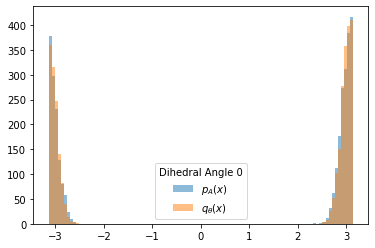

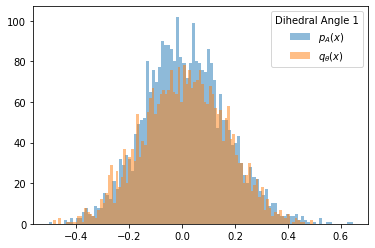

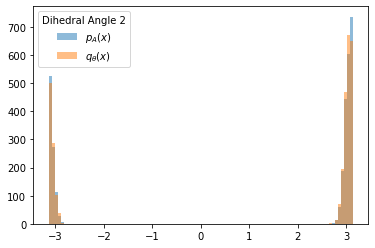

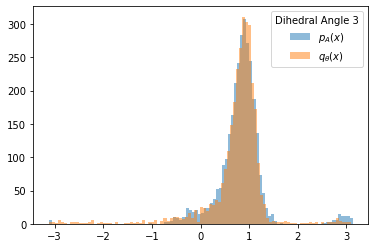

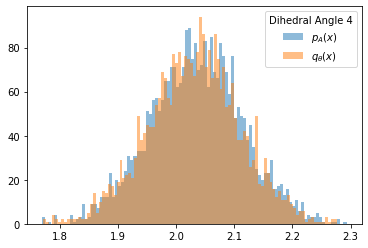

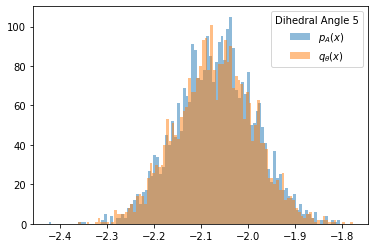

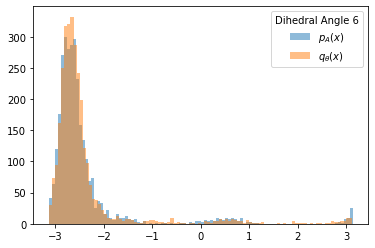

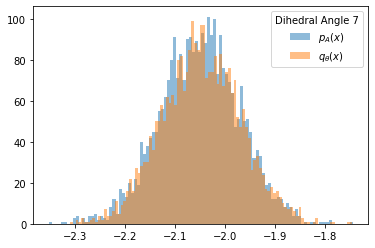

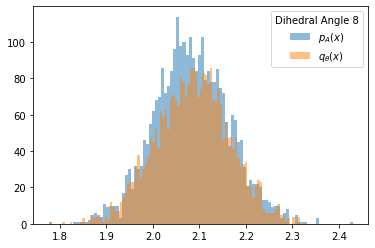

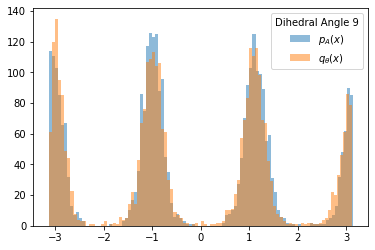

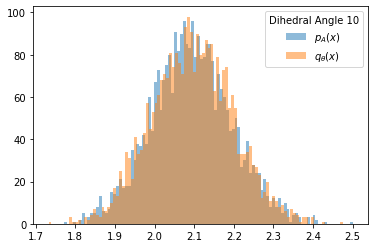

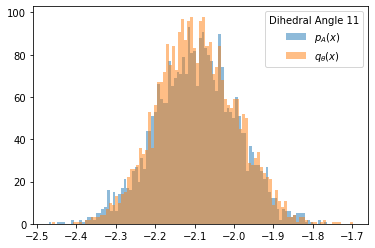

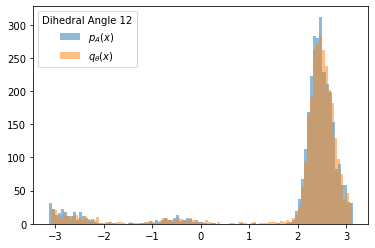

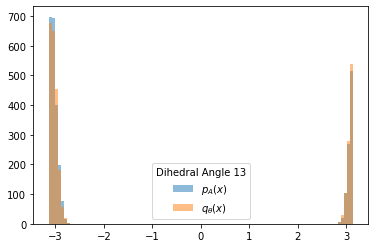

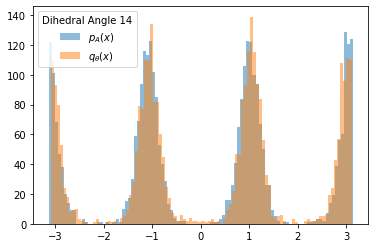

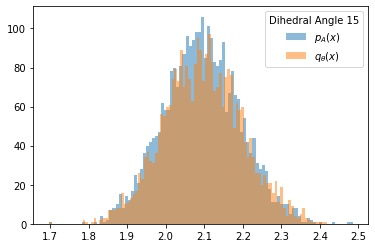

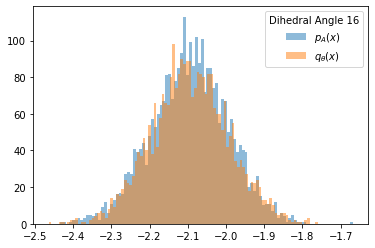

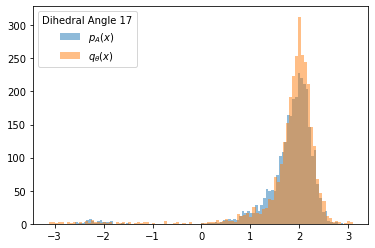

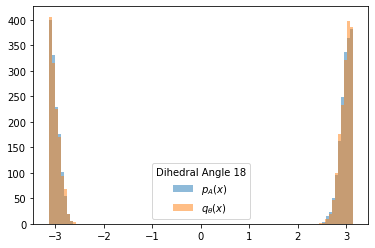

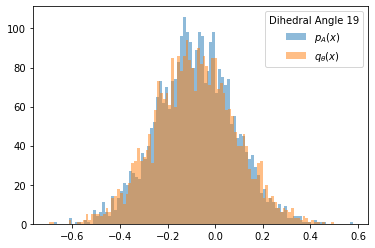

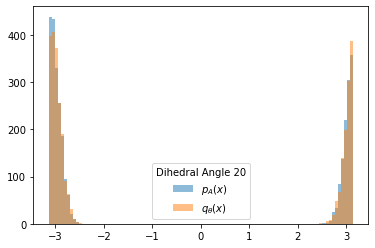

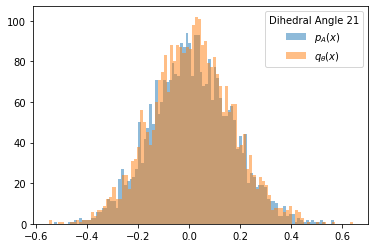

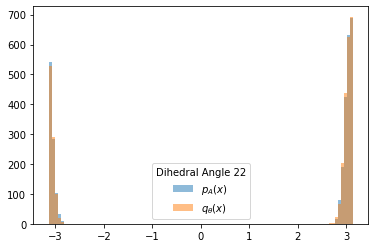

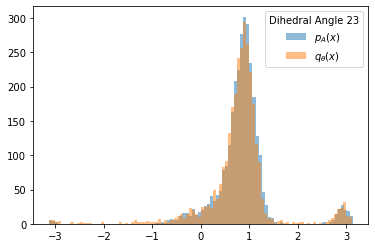

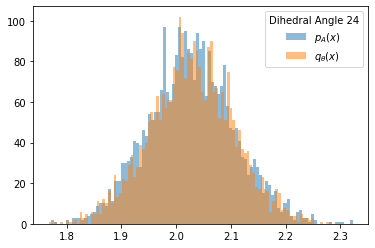

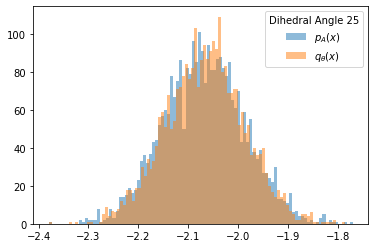

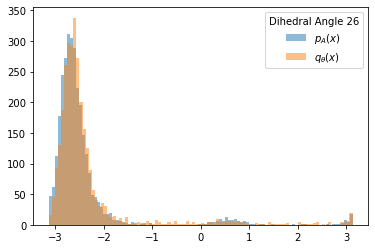

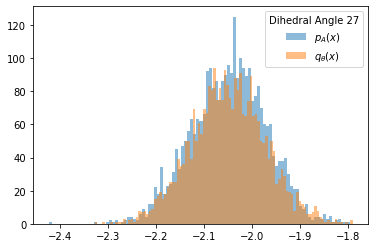

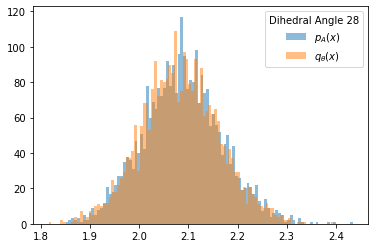

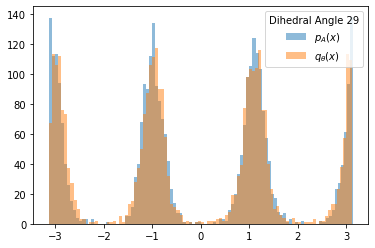

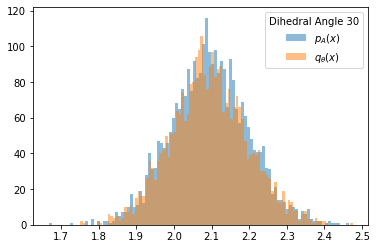

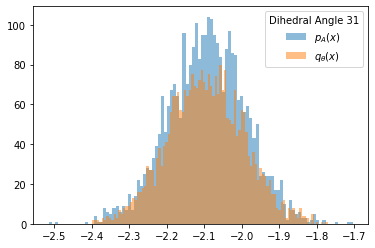

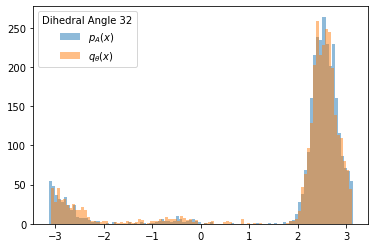

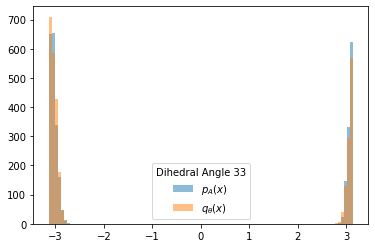

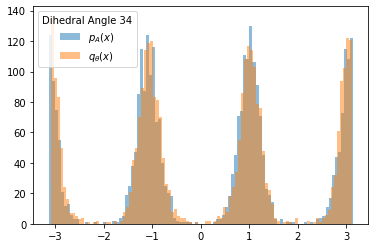

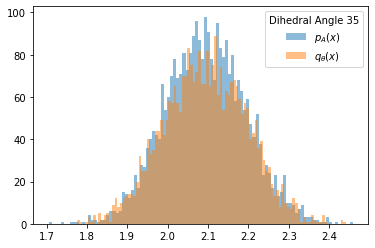

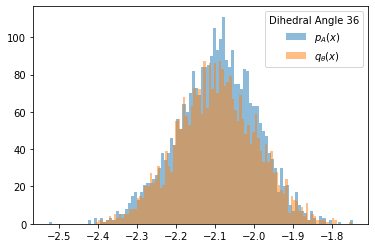

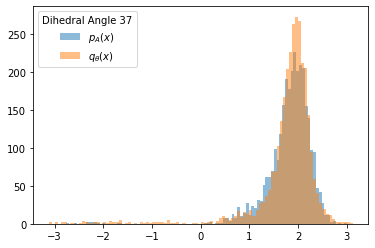

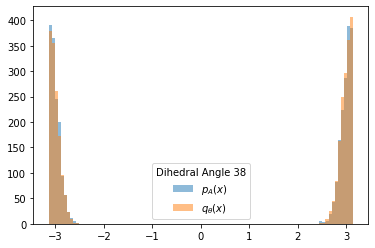

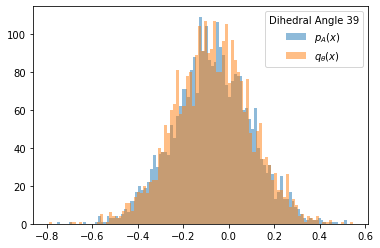

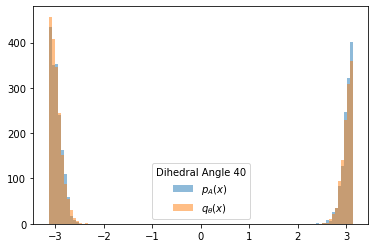

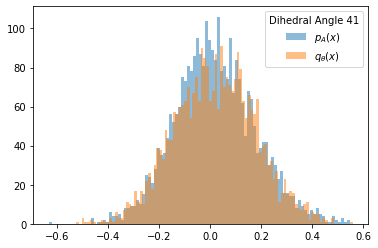

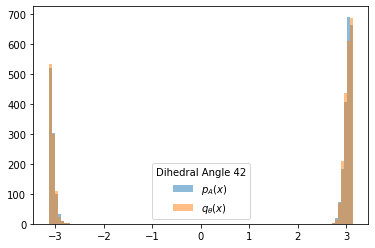

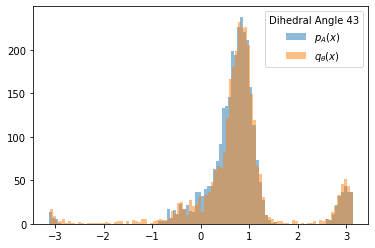

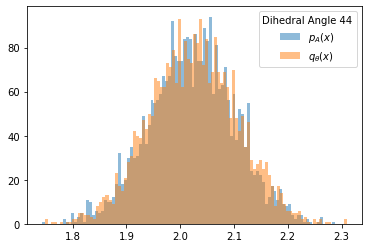

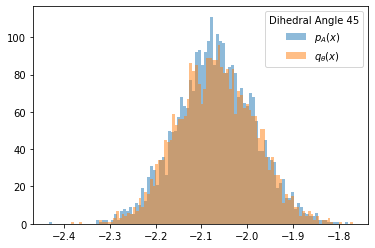

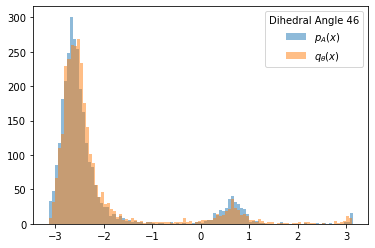

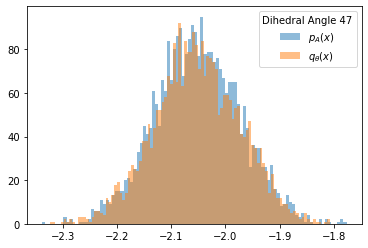

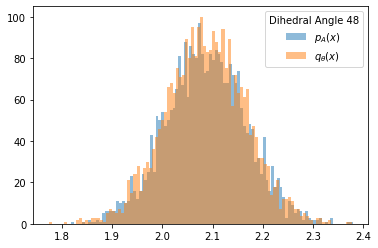

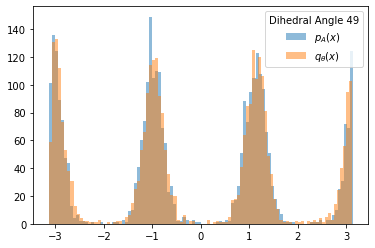

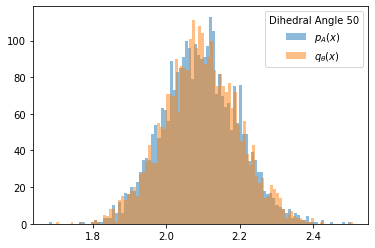

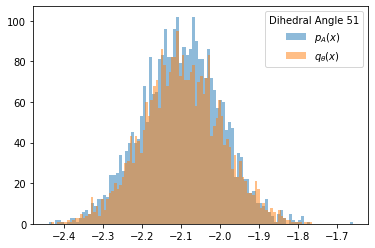

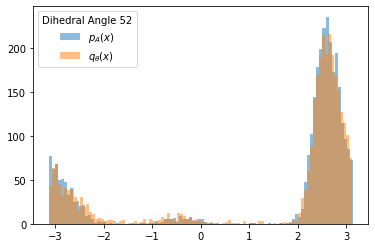

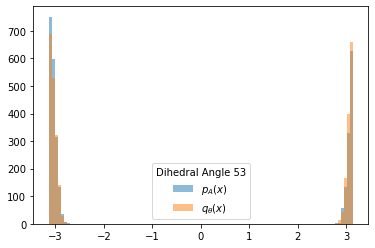

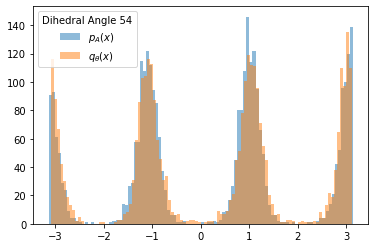

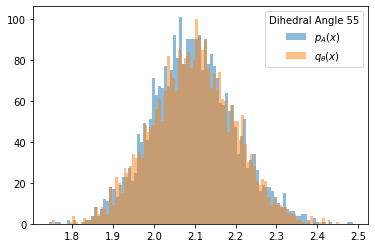

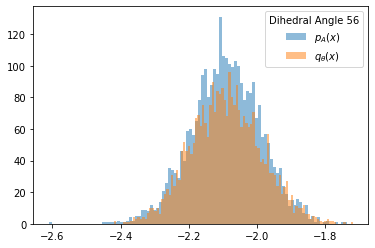

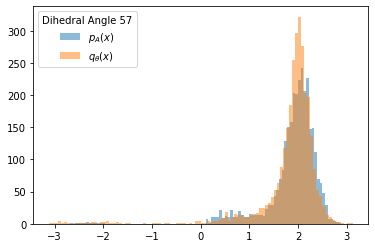

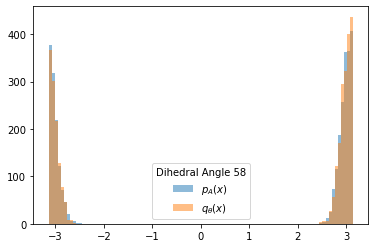

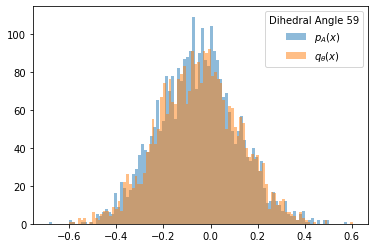

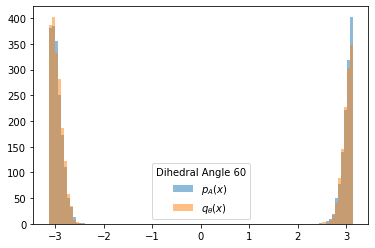

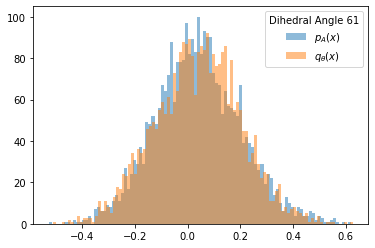

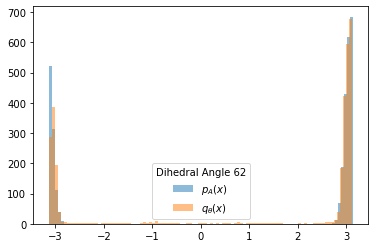

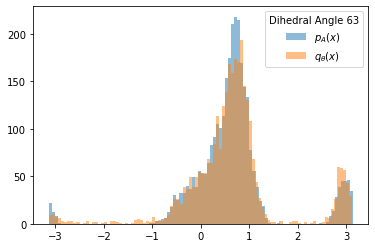

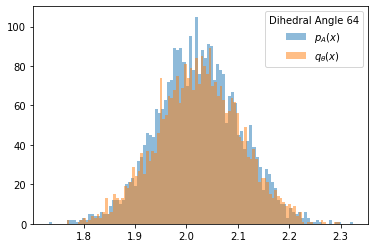

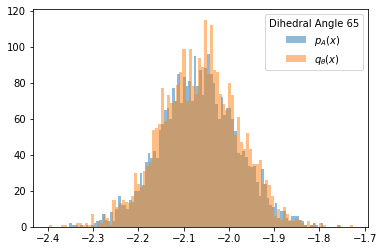

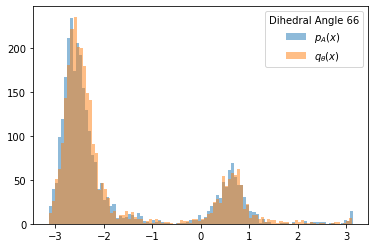

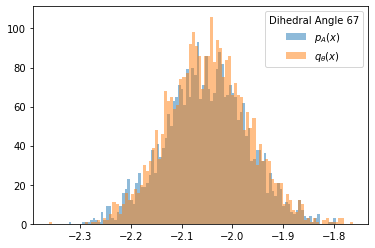

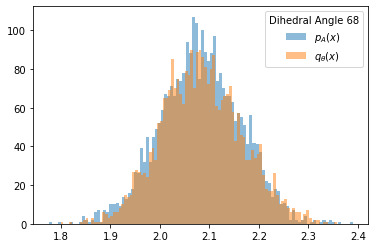

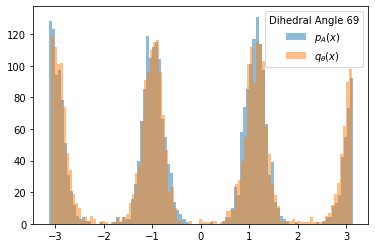

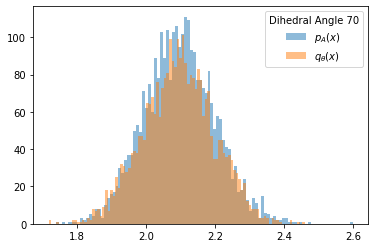

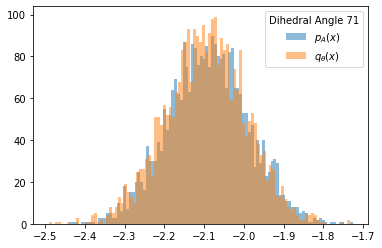

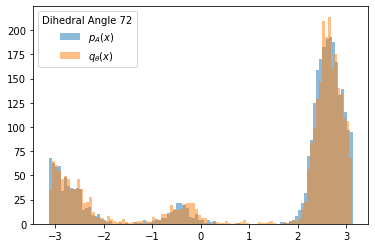

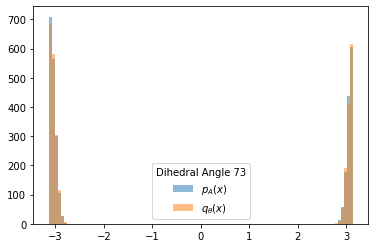

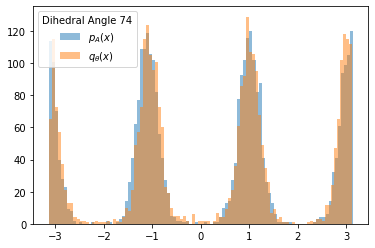

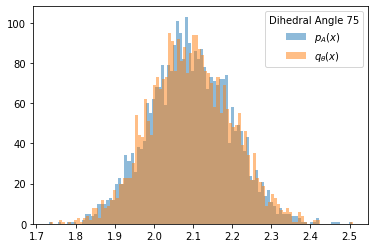

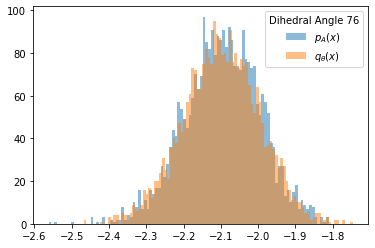

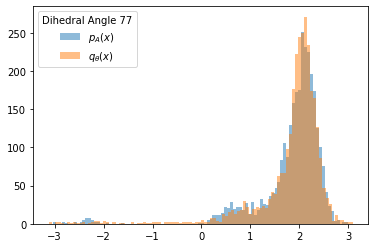

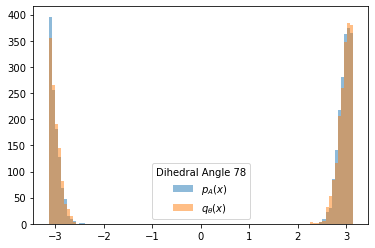

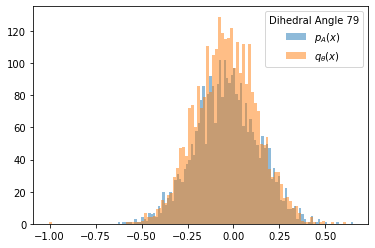

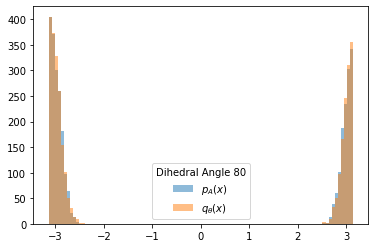

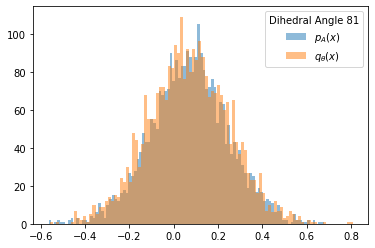

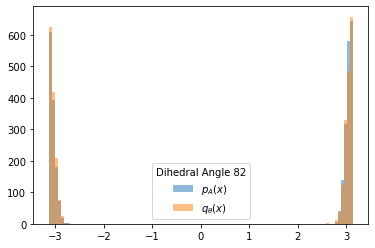

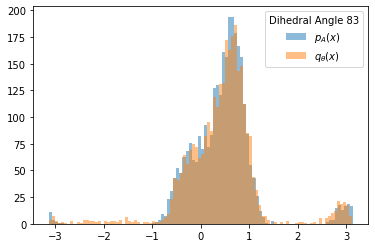

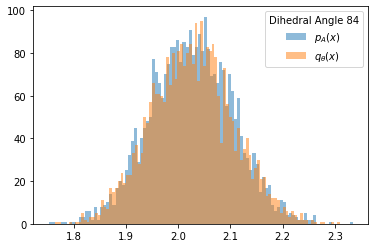

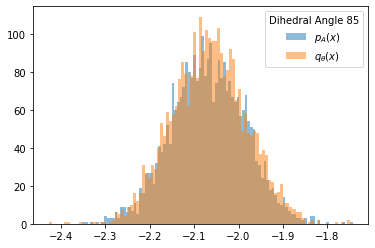

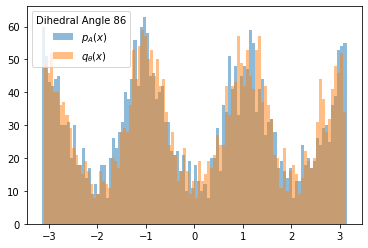

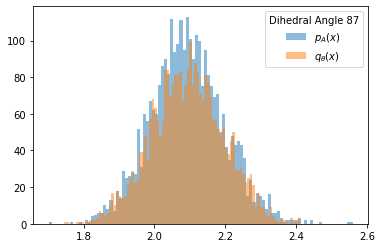

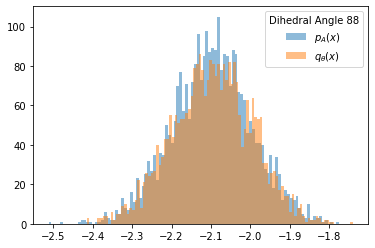

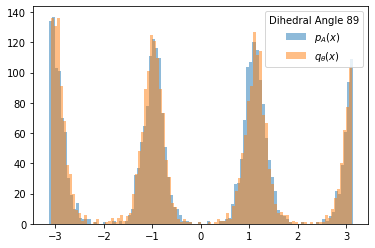

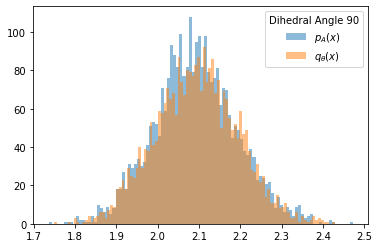

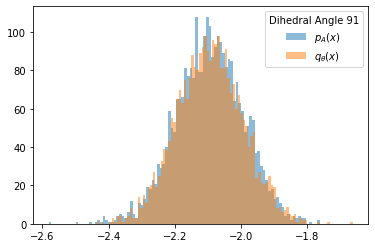

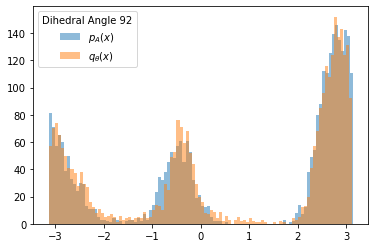

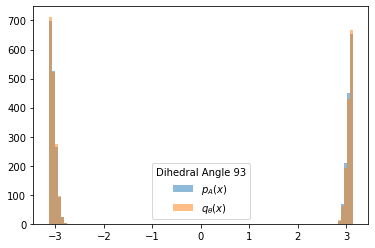

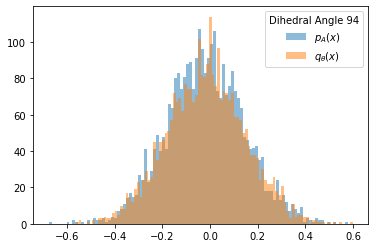

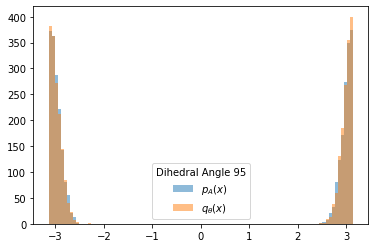

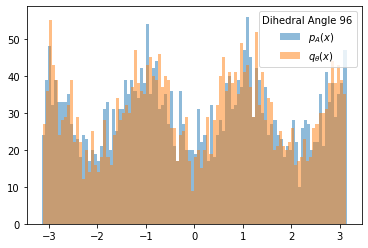

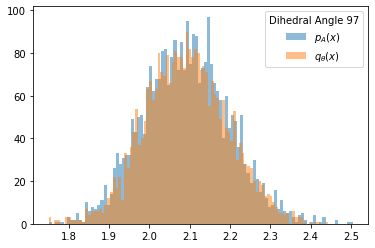

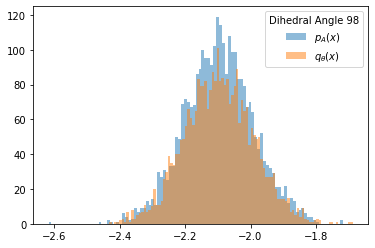

In [22]:
for index in range(0, 99, 1):
    indx = str(index)

    plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
    plt.hist(whole[:, index+201], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
    plt.legend(title = "Dihedral Angle " + indx)
    plt.show()

### Calculate Energies

In [23]:
molecules = utilities.rebuild(torch.tensor(whole))
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(molecules)

In [24]:
potential_energy_md = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

In [25]:
dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

In [26]:
p_x = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

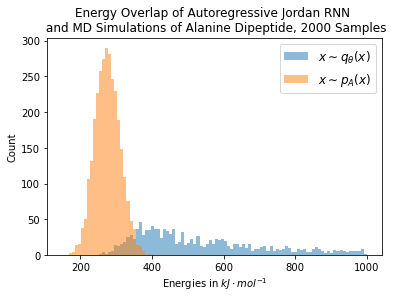

In [27]:
plt.hist(potential_energy_q_theta, range =(150, 1000), bins = 100, alpha = 0.5, label = "$x \sim q_{\\theta}(x)$")
plt.hist(potential_energy_md[:3000], range =(150, 1000), bins = 100, alpha = 0.5, label = "$x \sim p_A(x)$")
plt.title("Energy Overlap of Autoregressive Jordan RNN \n and MD Simulations of Alanine Dipeptide, 2000 Samples")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()